## Импорт библиотек

Загружаем необходимые модули: pandas/numpy для данных, torch для SVI,
sklearn для пайплайнов и метрик, matplotlib для визуализации.

In [1]:
# === Стандартные библиотеки ===
import warnings
from typing import List, Optional, Tuple, Union

# === Научные вычисления ===
import numpy as np
import pandas as pd

# === Визуализация ===
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# === PyTorch ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# === Scikit-learn ===
from sklearn import set_config as skl_set_config
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# === Загрузка данных ===
import gdown

# Настройки
warnings.filterwarnings('ignore')
skl_set_config(transform_output="pandas")

print('Библиотеки успешно загружены')

Библиотеки успешно загружены


## Загрузка данных

В работе анализируется датасет [Electricity Load Forecasting](https://www.kaggle.com/datasets/saurabhshahane/electricity-load-forecasting/data), который содержит информацию о нагрузке на электроэнергию в Панаме.

In [3]:
# Загрузка датасета
# !gdown 1SSXm1Yldoxb_je803ou1NKqVS-cHuDMp
df_full = pd.read_csv("continuous dataset.csv")
df_full

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48043,2020-06-26 20:00:00,1128.5592,27.246545,0.020303,0.055511,9.289304,25.715295,0.019746,0.121552,1.990773,23.746545,0.018381,0.150879,2.444658,0,0,1
48044,2020-06-26 21:00:00,1112.7488,27.099573,0.020395,0.053848,9.837504,25.552698,0.019632,0.153870,2.094459,23.693323,0.018320,0.156311,2.515814,0,0,1
48045,2020-06-26 22:00:00,1081.5680,26.971155,0.020448,0.057251,10.262464,25.393030,0.019518,0.144531,2.396369,23.658655,0.018327,0.153259,2.800717,0,0,1
48046,2020-06-26 23:00:00,1041.6240,26.867487,0.020464,0.064178,10.326567,25.258112,0.019403,0.108063,2.720871,23.601862,0.018358,0.152771,3.138132,0,0,1


Посмотрим на характеристики датасета.

In [4]:
print(f'Загружено строк: {len(df_full)}')
print(f'Столбцы: {list(df_full.columns)}')
df_full.info()
df_full.describe().T

Загружено строк: 48048
Столбцы: ['datetime', 'nat_demand', 'T2M_toc', 'QV2M_toc', 'TQL_toc', 'W2M_toc', 'T2M_san', 'QV2M_san', 'TQL_san', 'W2M_san', 'T2M_dav', 'QV2M_dav', 'TQL_dav', 'W2M_dav', 'Holiday_ID', 'holiday', 'school']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48048 entries, 0 to 48047
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    48048 non-null  object 
 1   nat_demand  48048 non-null  float64
 2   T2M_toc     48048 non-null  float64
 3   QV2M_toc    48048 non-null  float64
 4   TQL_toc     48048 non-null  float64
 5   W2M_toc     48048 non-null  float64
 6   T2M_san     48048 non-null  float64
 7   QV2M_san    48048 non-null  float64
 8   TQL_san     48048 non-null  float64
 9   W2M_san     48048 non-null  float64
 10  T2M_dav     48048 non-null  float64
 11  QV2M_dav    48048 non-null  float64
 12  TQL_dav     48048 non-null  float64
 13  W2M_dav     48048 non-null  float64
 14  H

,count,mean,std,min,25%,50%,75%,max
nat_demand,48048.0,1182.868647,192.068896,85.192500,1020.056900,1168.427700,1327.563950,1754.882000
T2M_toc,48048.0,27.399111,1.675462,22.953455,26.160455,27.118051,28.558344,35.039575
QV2M_toc,48048.0,0.018313,0.001607,0.012054,0.017236,0.018590,0.019521,0.022690
TQL_toc,48048.0,0.079979,0.065589,0.000000,0.026451,0.065201,0.117310,0.521240
W2M_toc,48048.0,13.391049,7.295502,0.008979,7.544958,12.182103,18.661282,39.229726
T2M_san,48048.0,26.921023,3.018129,19.765222,24.769281,26.167352,28.712335,39.063440
QV2M_san,48048.0,0.017844,0.001889,0.010247,0.016584,0.018351,0.019242,0.022165
TQL_san,48048.0,0.106265,0.086293,0.000009,0.036819,0.085968,0.157288,0.484985
W2M_san,48048.0,7.046675,4.103711,0.060394,3.955051,5.992762,9.409871,24.483937
T2M_dav,48048.0,24.719513,2.414019,19.933740,22.954652,24.001718,26.243402,34.216211


Подготовка временного индекса.

In [5]:
df = df_full.copy()

df["datetime"] = pd.to_datetime(df["datetime"])

df = (
    df.sort_values("datetime")
      .reset_index(drop=True)
      .set_index("datetime")
)

df.head()

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


Проанализируем признаки датасета.

Часть признакова датасета имеют суффиксы, которые обозначают города в Панаме: 
- **toc** - Tocumen
- **san** - Santiago
- **dav** - David

Признаки с суффиксами:
- **T2M** - Температура воздуха на высоте 2 м.
- **QV2M** - Удельная влажность воздуха на высоте 2 м.
- **TQL** - Количество жидкой воды в облаках (cloud liquid water content).
- **W2M** - Скорость ветра на высоте 2 м.

Признаки без суффиксов:
- **Holiday_ID** - Идентификатор конкретного праздника (0 — нет праздника)
- **holiday** - Бинарный флаг: 1 — официальный праздник, 0 — нет
- **school** - Бинарный флаг школьных каникул: 1 — каникулы, 0 — учебный период

Целевая переменная - **nat_demand**. Она показывает национальное потребление электричества.

Визуализация целевой переменной

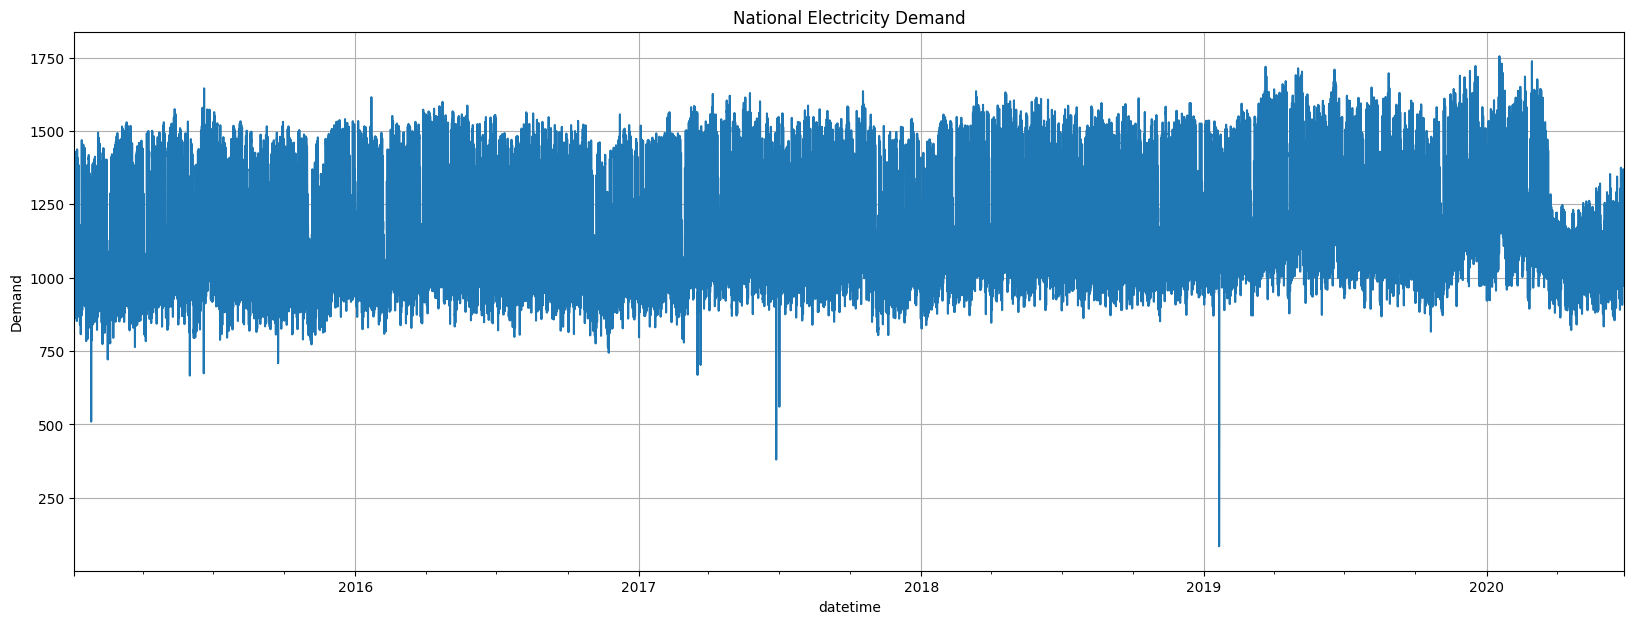

In [6]:
df["nat_demand"].plot(figsize=(20, 7), grid=True)
plt.title("National Electricity Demand")
plt.ylabel("Demand")
plt.show()

## Предобработка данных

In [9]:
# Приводим бинаризированные признаки к float:
df["holiday"] = df["holiday"].astype(float)
df["school"] = df["school"].astype(float)

# Выбор признаков для модели
FEATURES = [
    "T2M_toc",
    "T2M_san",
    "T2M_dav",
    "holiday",
    "school",
    "nat_demand"  # включаем target для создания лагов
]

TARGET = "nat_demand"

df = df[FEATURES].dropna()

print(f"Количество записей: {len(df)}")
df.head()

Количество записей: 48048


,T2M_toc,T2M_san,T2M_dav,holiday,school,nat_demand
datetime,,,,,,
2015-01-03 01:00:00,25.865259,23.482446,22.662134,0.0,0.0,970.3450
2015-01-03 02:00:00,25.899255,23.399255,22.578943,0.0,0.0,912.1755
2015-01-03 03:00:00,25.937280,23.343530,22.531030,0.0,0.0,900.2688
2015-01-03 04:00:00,25.957544,23.238794,22.512231,0.0,0.0,889.9538
2015-01-03 05:00:00,25.973840,23.075403,22.481653,0.0,0.0,893.6865


## Разбиение на train/val/test

Для контроля качества обучения моделей и оценки предсказаний требуется разделить датасет на обущающую, валидационную и тестовую части. Для временных рядов стандартным является временнОе разбиение 70/15/15 с сохранением хронологии.

In [45]:
# Гиперпараметр: глубина лагов (запаздывания по времени)
N_LAGS = 10  

# Индексы для разбиения 70/15/15
train_end = int(0.70 * len(df))
val_end = int(0.85 * len(df))

# Разбиение данных
X_train = df[:train_end]
y_train = df[[TARGET]][:train_end]

X_val = df[train_end:val_end]
y_val = df[[TARGET]][train_end:val_end]

X_test = df[val_end:]
y_test = df[[TARGET]][val_end:]




# Даты для графиков
dates_test = y_test.index.to_numpy()

## Трансформер для лаговых признаков

Создаёт признаки с задержкой (lag) для авторегрессии.

In [46]:
class LaggedFeaturesTransformer(BaseEstimator, TransformerMixin):
    """Создаёт лаговые признаки для авторегрессионных моделей.

    Attributes:
        n_lags: Количество временных лагов.
        feature_names_in_: Имена входных признаков.
    """

    def __init__(self, n_lags: int = 5) -> None:
        """Инициализация трансформера.

        Args:
            n_lags: Количество лагов для создания.
        """
        self.n_lags = n_lags
        self.feature_names_in_: Optional[List[str]] = None

    def fit(
        self,
        X: Union[pd.DataFrame, np.ndarray],
        y: Optional[np.ndarray] = None
    ) -> 'LaggedFeaturesTransformer':
        """Запоминает названия колонок.

        Args:
            X: Входные данные.
            y: Целевая переменная (не используется).

        Returns:
            self: Обученный трансформер.
        """
        if isinstance(X, pd.DataFrame):
            self.feature_names_in_ = list(X.columns)
        else:
            # Генерируем имена для numpy array
            n_features = X.shape[1]
            self.feature_names_in_ = [
                f"feature_{i}" for i in range(n_features)
            ]
        return self

    def transform(
        self,
        X: Union[pd.DataFrame, np.ndarray]
    ) -> pd.DataFrame:
        """Создаёт лаговые признаки.

        Args:
            X: Входные данные.

        Returns:
            DataFrame с лаговыми признаками.
        """
        # Преобразуем в numpy для скорости
        X_values = X.values if isinstance(X, pd.DataFrame) else X
        n_samples, _ = X_values.shape

        # Сборка лагов через срезы
        lagged_arrays = []
        for lag in range(1, self.n_lags + 1):
            start = self.n_lags - lag
            end = n_samples - lag
            lagged_arrays.append(X_values[start:end])

        X_transformed = np.hstack(lagged_arrays)

        # Генерация имён колонок: feature_lag1, feature_lag2, ...
        new_columns = [
            f"{feat}_lag{lag}"
            for lag in range(1, self.n_lags + 1)
            for feat in self.feature_names_in_
        ]

        return pd.DataFrame(X_transformed, columns=new_columns)


print('LaggedFeaturesTransformer создан')

LaggedFeaturesTransformer создан


## Ridge-регрессия с кросс-валидацией

Реализуем классическую регрессию в виде scikit-learn-эстиматора, обернув в него `Ridge`-регрессию с автоподбором гиперпараметра $L_2$-регуляризации $\alpha$ с помощью `TimeSeriesSplit`.

In [47]:
class RidgeRegressionCV(BaseEstimator, RegressorMixin):
    """Ridge-регрессия с кросс-валидацией по временным рядам.

    Attributes:
        alphas: Список значений alpha для перебора.
        n_splits: Число фолдов для TimeSeriesSplit.
        best_model_: Лучшая обученная модель.
        best_alpha_: Лучшее значение alpha.
    """

    def __init__(
        self,
        alphas: Optional[List[float]] = None,
        n_splits: int = 5
    ) -> None:
        """Инициализация модели.

        Args:
            alphas: Значения регуляризации для перебора.
            n_splits: Число фолдов кросс-валидации.
        """
        self.alphas = alphas or [0.001, 0.01, 0.1, 1, 10, 100]
        self.n_splits = n_splits
        self.best_model_: Optional[Ridge] = None
        self.best_alpha_: Optional[float] = None

    def fit(
        self,
        X: Union[pd.DataFrame, np.ndarray],
        y: Union[pd.Series, np.ndarray]
    ) -> 'RidgeRegressionCV':
        """Обучение с подбором гиперпараметров.

        Args:
            X: Матрица признаков.
            y: Целевая переменная.

        Returns:
            self: Обученная модель.
        """
        tscv = TimeSeriesSplit(n_splits=self.n_splits)
        param_grid = {'alpha': self.alphas}

        grid_search = GridSearchCV(
            Ridge(),
            param_grid,
            cv=tscv,
            scoring='neg_mean_squared_error',
            n_jobs=-1
        )
        grid_search.fit(X, y)

        self.best_model_ = grid_search.best_estimator_
        self.best_alpha_ = grid_search.best_params_['alpha']
        return self

    def predict(
        self,
        X: Union[pd.DataFrame, np.ndarray]
    ) -> np.ndarray:
        """Предсказание.

        Args:
            X: Матрица признаков.

        Returns:
            Предсказанные значения.
        """
        return self.best_model_.predict(X)

    def get_params(self, deep: bool = True) -> dict:
        """Получение параметров для sklearn."""
        return {'alphas': self.alphas, 'n_splits': self.n_splits}

    def set_params(self, **params) -> 'RidgeRegressionCV':
        """Установка параметров для sklearn."""
        for key, value in params.items():
            setattr(self, key, value)
        return self


print('RidgeRegressionCV создан')

RidgeRegressionCV создан


## Байесовская линейная модель (PyTorch)

Реализуем байесовскую линейную регрессию с глобальными случайными весами и свободным коэффициентом.

In [48]:
class BayesianLinearModel(nn.Module):
    """Байесовская линейная регрессия с вариационным выводом.

    Использует Mean-Field Approximation: q(w) = N(μ, diag(σ²)).

    Attributes:
        num_features: Размерность входа.
        prior_std: СКО априорного распределения весов.
    """

    def __init__(self, num_features: int, prior_std: float = 0.01) -> None:
        """Инициализация модели.

        Args:
            num_features: Число входных признаков.
            prior_std: Стандартное отклонение априора.
        """
        super().__init__()
        self.num_features = num_features
        self.prior_std = prior_std

        # Вариационные параметры весов: μ и ρ (σ = softplus(ρ))
        self.mu_w = nn.Parameter(torch.zeros(num_features))
        self.rho_w = nn.Parameter(torch.full((num_features,), -3.0))

        # Вариационные параметры bias
        self.mu_b = nn.Parameter(torch.zeros(1))
        self.rho_b = nn.Parameter(torch.tensor(-3.0))

        # Шум наблюдений (обучаемый)
        self.rho_noise = nn.Parameter(torch.tensor([0.0]))

    @property
    def sigma_w(self) -> torch.Tensor:
        """СКО весов: σ = softplus(ρ) + ε."""
        return F.softplus(self.rho_w) + 1e-6

    @property
    def sigma_b(self) -> torch.Tensor:
        """СКО bias."""
        return F.softplus(self.rho_b) + 1e-6

    @property
    def noise_std(self) -> torch.Tensor:
        """СКО шума наблюдений."""
        return F.softplus(self.rho_noise) + 1e-6

    def forward(
        self,
        X: torch.Tensor,
        num_samples: int = 1
    ) -> torch.Tensor:
        """Прямой проход с сэмплированием весов.

        Args:
            X: Входной тензор (batch_size, num_features).
            num_samples: Число сэмплов весов.

        Returns:
            Предсказания (batch_size, num_samples).
        """
        # Reparameterization trick: w = μ + σ * ε
        eps_w = torch.randn(
            num_samples, self.num_features, device=X.device
        )
        w = self.mu_w + self.sigma_w * eps_w

        eps_b = torch.randn(num_samples, 1, device=X.device)
        b = self.mu_b + self.sigma_b * eps_b

        # Линейная регрессия: y = X @ w.T + b
        y_pred = F.linear(X, w, b.squeeze(-1))
        return y_pred

    def kl_divergence(self) -> torch.Tensor:
        """Аналитический KL(q(w) || p(w)).

        Returns:
            Значение KL-дивергенции.
        """
        prior_var = self.prior_std ** 2

        # KL для весов
        kl_w = 0.5 * torch.sum(
            (self.sigma_w**2 + self.mu_w**2) / prior_var
            - 1
            - 2 * torch.log(self.sigma_w / self.prior_std)
        )

        # KL для bias
        kl_b = 0.5 * torch.sum(
            (self.sigma_b**2 + self.mu_b**2) / prior_var
            - 1
            - 2 * torch.log(self.sigma_b / self.prior_std)
        )

        return kl_w + kl_b

## Sklearn-обёртка для SVI

Аналогичным образом, обернём байесовскую регрессию в scikit-learn-эстиматор и предиктор.

In [49]:
class BayesianRegressorSVI(BaseEstimator, RegressorMixin):
    """Байесовская регрессия с Stochastic Variational Inference.

    Attributes:
        num_epochs: Число эпох обучения.
        lr: Скорость обучения.
        batch_size: Размер мини-батча.
        prior_std: СКО априора.
        num_train_samples: MC-сэмплов при обучении.
    """

    def __init__(
        self,
        num_epochs: int = 1000,
        lr: float = 0.001,
        batch_size: int = 64,
        prior_std: float = 0.01,
        num_train_samples: int = 1,
        random_state: Optional[int] = None,
        device: str = 'cpu'
    ) -> None:
        """Инициализация модели.

        Args:
            num_epochs: Количество эпох.
            lr: Learning rate.
            batch_size: Размер батча.
            prior_std: СКО априорного распределения.
            num_train_samples: Число сэмплов для оценки ELBO.
            random_state: Seed для воспроизводимости.
            device: Устройство (cpu/cuda).
        """
        self.num_epochs = num_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.prior_std = prior_std
        self.num_train_samples = num_train_samples
        self.random_state = random_state
        self.device = device
        self.model: Optional[BayesianLinearModel] = None
        self.losses: List[float] = []

    def fit(
        self,
        X: Union[pd.DataFrame, np.ndarray],
        y: Union[pd.Series, np.ndarray]
    ) -> 'BayesianRegressorSVI':
        """Обучение методом SVI.

        Args:
            X: Матрица признаков.
            y: Целевая переменная.

        Returns:
            self: Обученная модель.
        """
        if self.random_state:
            torch.manual_seed(self.random_state)
            np.random.seed(self.random_state)

        # Конвертация в тензоры
        X_arr = X.values if hasattr(X, 'values') else X
        y_arr = y.values if hasattr(y, 'values') else y

        X_t = torch.tensor(X_arr, dtype=torch.float32).to(self.device)
        y_t = torch.tensor(y_arr, dtype=torch.float32)
        y_t = y_t.view(-1).to(self.device)

        dataset_size, num_features = X_t.shape

        # Инициализация модели
        self.model = BayesianLinearModel(
            num_features, self.prior_std
        ).to(self.device)

        # DataLoader для батчей
        dataset = TensorDataset(X_t, y_t)
        loader = DataLoader(
            dataset, batch_size=self.batch_size, shuffle=True
        )

        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.model.train()
        self.losses = []

        for epoch in range(self.num_epochs):
            epoch_loss = 0.0

            for X_batch, y_batch in loader:
                optimizer.zero_grad()

                # Forward: (batch_size, num_samples)
                preds = self.model(
                    X_batch, num_samples=self.num_train_samples
                )

                # Log Likelihood
                ll_matrix = torch.distributions.Normal(
                    preds, self.model.noise_std
                ).log_prob(y_batch.view(-1, 1))

                # Среднее по сэмплам, сумма по батчу
                ll_batch_sum = ll_matrix.mean(dim=1).sum()

                # KL с масштабированием по размеру батча
                kl = self.model.kl_divergence()
                kl_weight = len(X_batch) / dataset_size

                # Loss = -ELBO
                loss = -ll_batch_sum + kl * kl_weight

                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

            # Отображаем процесс обучения
            print(f"Epoch: {epoch:3d} | Loss: {epoch_loss:10.4f}")
            self.losses.append(epoch_loss)

        return self

    def predict(
        self,
        X: Union[pd.DataFrame, np.ndarray],
        num_pred_samples: int = 1,
        return_samples: bool = False
    ) -> np.ndarray:
        """Предсказание с posterior predictive.

        Args:
            X: Матрица признаков.
            num_pred_samples: Число сэмплов на этапе предсказания.
            return_samples: Вернуть все сэмплы или же их среднее.

        Returns:
            Если return_samples=True: (batch, num_samples).
            Иначе: (batch,) — среднее.
        """
        self.model.eval()
        X_arr = X.values if hasattr(X, 'values') else X
        X_t = torch.tensor(X_arr, dtype=torch.float32).to(self.device)

        with torch.no_grad():
            # Epistemic uncertainty (из весов)
            preds = self.model(X_t, num_samples=num_pred_samples)

            # Aleatoric uncertainty (шум данных)
            # noise = torch.randn_like(preds) * self.model.noise_std
            # preds_with_noise = preds + noise

            # result = preds_with_noise.cpu().numpy()

            result = preds.cpu().numpy()

        if return_samples:
            return result

        return result.mean(axis=1)

## Препроцессор и пайплайны

Формируем scikit-learn-конвейер для преобразования признаков и обучения модели.
Количественные признаки нуждаются в масштабировании.

In [50]:
# Препроцессор: масштабирование числовых признаков
preprocessor = ColumnTransformer(
    transformers=[
        (
            'scaler',
            StandardScaler(),
            [
                'T2M_toc',
                'T2M_san',
                'T2M_dav'
            ]
        )
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [51]:
# Pipeline для Ridge-регрессии
pipeline_ridge = Pipeline([
    ('preprocessor', preprocessor),
    ('lagger', LaggedFeaturesTransformer(n_lags=N_LAGS)),
    ('model', RidgeRegressionCV())
])
pipeline_ridge

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['T2M_toc', 'T2M_san',
                                                   'T2M_dav'])],
                                   verbose_feature_names_out=False)),
                ('lagger', LaggedFeaturesTransformer(n_lags=10)),
                ('model',
                 RidgeRegressionCV(alphas=[0.001, 0.01, 0.1, 1, 10, 100]))])

In [52]:
# Pipeline для байесовской регрессии
pipeline_bayesian = Pipeline([
    ('preprocessor', preprocessor),
    ('lagger', LaggedFeaturesTransformer(n_lags=N_LAGS)),
    ('model', BayesianRegressorSVI(
        num_epochs=400,
        lr=0.001,
        batch_size=64,
        num_train_samples=128
    ))
])
pipeline_bayesian

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['T2M_toc', 'T2M_san',
                                                   'T2M_dav'])],
                                   verbose_feature_names_out=False)),
                ('lagger', LaggedFeaturesTransformer(n_lags=10)),
                ('model',
                 BayesianRegressorSVI(num_epochs=400, num_train_samples=128))])

## Вспомогательные функции

In [53]:
def lag_label(data: pd.DataFrame, num_lags: int = N_LAGS) -> pd.Series:
    """Сдвиг целевой переменной для соответствия лаговым признакам.

    Args:
        data: DataFrame с колонкой nat_demand.
        num_lags: Число лагов для сдвига.

    Returns:
        Series с целевой переменной без первых num_lags значений.
    """
    return data.reset_index()['nat_demand'][num_lags:]

## Обучение моделей

In [54]:
print('Обучение Ridge...')
pipeline_ridge.fit(X_train, lag_label(y_train))
print(f'  Лучший alpha: {pipeline_ridge.named_steps["model"].best_alpha_}')

print('Обучение Bayesian SVI...')
pipeline_bayesian.fit(X_train, lag_label(y_train))
print('Все модели обучены!')

Обучение Ridge...
  Лучший alpha: 1
Обучение Bayesian SVI...
Epoch:   0 | Loss: 5293906557.3750
Epoch:   1 | Loss: 1190161819.5625
Epoch:   2 | Loss: 754086572.9375
Epoch:   3 | Loss: 497317850.2812
Epoch:   4 | Loss: 343296041.8750
Epoch:   5 | Loss: 249293620.2656
Epoch:   6 | Loss: 188810794.3359
Epoch:   7 | Loss: 147499773.3750
Epoch:   8 | Loss: 118707670.5664
Epoch:   9 | Loss: 96512385.5977
Epoch:  10 | Loss: 79564896.7031
Epoch:  11 | Loss: 66094681.6758
Epoch:  12 | Loss: 55058358.0195
Epoch:  13 | Loss: 46214995.5195
Epoch:  14 | Loss: 38855991.0088
Epoch:  15 | Loss: 32765833.6201
Epoch:  16 | Loss: 27729883.5498
Epoch:  17 | Loss: 23539827.9839
Epoch:  18 | Loss: 20073042.9004
Epoch:  19 | Loss: 17122434.2217
Epoch:  20 | Loss: 14691778.1582
Epoch:  21 | Loss: 12614635.3330
Epoch:  22 | Loss: 10873803.9634
Epoch:  23 | Loss: 9431107.2656
Epoch:  24 | Loss: 8184192.9839
Epoch:  25 | Loss: 7125758.7002
Epoch:  26 | Loss: 6225139.5742
Epoch:  27 | Loss: 5450343.6638
Epoch:  2

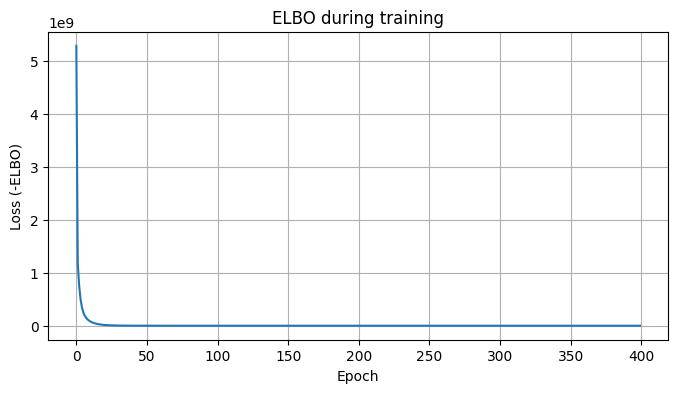

[5293906557.375, 1190161819.5625, 754086572.9375, 497317850.28125, 343296041.875, 249293620.265625, 188810794.3359375, 147499773.375, 118707670.56640625, 96512385.59765625, 79564896.703125, 66094681.67578125, 55058358.01953125, 46214995.51953125, 38855991.00878906, 32765833.620117188, 27729883.549804688, 23539827.98388672, 20073042.900390625, 17122434.221679688, 14691778.158203125, 12614635.333007812, 10873803.963378906, 9431107.265625, 8184192.983886719, 7125758.7001953125, 6225139.57421875, 5450343.663818359, 4796029.780761719, 4209855.319824219, 3737190.744995117, 3306156.794921875, 2936789.728881836, 2609264.0197753906, 2331012.266357422, 2095594.0786132812, 1876583.5987548828, 1690276.996887207, 1525525.9700927734, 1387894.715637207, 1259706.5080566406, 1155323.8540039062, 1056052.8061523438, 974623.6184997559, 898472.3735961914, 832146.2072753906, 774420.0221557617, 721906.4784545898, 674316.5166931152, 630810.3796691895, 594318.1752624512, 558168.5381164551, 528124.9821166992, 5

In [55]:
plt.figure(figsize=(8,4))
plt.plot(pipeline_bayesian.named_steps['model'].losses)
plt.title("ELBO during training")
plt.xlabel("Epoch")
plt.ylabel("Loss (-ELBO)")
plt.grid()
plt.show()

losses = pipeline_bayesian.named_steps['model'].losses
print(losses)

## Валидация (прямой прогноз)

In [59]:
def evaluate_model(
    name: str,
    y_true: np.ndarray,
    y_pred: np.ndarray
) -> dict:
    """Вычисление метрик качества.

    Args:
        name: Название модели.
        y_true: Истинные значения.
        y_pred: Предсказанные значения.

    Returns:
        Словарь с метриками RMSE, MAE, R².
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'Model': name, 'RMSE': rmse, 'MAE': mae, 'R2': r2}


# Оценка на валидации
results_val = []

pred_ridge_val = pipeline_ridge.predict(X_val)
results_val.append(
    evaluate_model('Ridge', lag_label(y_val).to_numpy(), pred_ridge_val)
)

pred_bayes_val = pipeline_bayesian.predict(X_val)
results_val.append(
    evaluate_model('Bayesian SVI', lag_label(y_val).to_numpy(), pred_bayes_val)
)

print('Результаты на валидации (прямой прогноз):')
pd.DataFrame(results_val)

Результаты на валидации (прямой прогноз):


,Model,RMSE,MAE,R2
0,Ridge,36.766434,26.552947,0.961936
1,Bayesian SVI,47.514550,34.375367,0.936428


## Авторегрессионный прогноз

Предсказания предыдущих шагов используются как входные признаки.

Формируем функции для выполнения авторегрессионного предсказания значений ряда.

In [60]:
def autoregressive_forecast_classic_pipeline(
    pipeline: Pipeline,
    test_data: pd.DataFrame,
    num_lags: int,
    target_col: str = 'nat_demand'
) -> np.ndarray:
    """Авторегрессионный прогноз для классических моделей.

    Args:
        pipeline: Обученный sklearn pipeline.
        test_data: Тестовые данные.
        num_lags: Число лагов.
        target_col: Имя целевой колонки.

    Returns:
        Массив предсказаний.
    """
    df_test = test_data.copy().reset_index(drop=True)
    df_test[target_col][num_lags:] = np.nan
    y_preds = []

    for i in range(0, len(df_test.index) - num_lags):
        y_pred = pipeline.predict(df_test[i:i + num_lags + 1])
        df_test["nat_demand"].iloc[i + num_lags] = y_pred
        y_preds.append(y_pred)

    return np.concatenate(y_preds)

In [61]:
def autoregressive_forecast_bayesian_pipeline(
    pipeline: Pipeline,
    test_data: pd.DataFrame,
    num_lags: int,
    num_pred_samples: int = 1024,
    target_col: str = 'nat_demand'
) -> Tuple[np.ndarray, np.ndarray]:
    """Авторегрессионный прогноз для байесовской модели.

    Args:
        pipeline: Обученный sklearn pipeline.
        test_data: Тестовые данные.
        num_lags: Число лагов.
        num_pred_samples: Число MC-сэмплов для неопределённости.
        target_col: Имя целевой колонки.

    Returns:
        Кортеж (средние предсказания, стандартные отклонения).
    """
    df_test = test_data.copy().reset_index(drop=True)
    df_test[target_col][num_lags:] = np.nan
    y_preds_mean = []
    y_preds_std = []

    for i in range(0, len(df_test.index) - num_lags):
        y_pred = pipeline.predict(
            df_test[i:i + num_lags + 1],
            num_pred_samples=num_pred_samples,
            return_samples=True
        )
        y_pred_mean = y_pred.mean(axis=1)
        y_pred_std = y_pred.std(axis=1)

        df_test["nat_demand"].iloc[i + num_lags] = y_pred_mean
        y_preds_mean.append(y_pred_mean)
        y_preds_std.append(y_pred_std)

    return np.concatenate(y_preds_mean), np.concatenate(y_preds_std)

Выполняем авторегрессионное прогнозирование для обеих моделей.

In [62]:
# Авторегрессионные прогнозы
print('Ridge AR...')
pred_ridge_ar = autoregressive_forecast_classic_pipeline(
    pipeline_ridge,
    X_test,
    num_lags=N_LAGS
)

print('Bayesian SVI AR...')
pred_bayes_ar, std_bayes_ar = autoregressive_forecast_bayesian_pipeline(
    pipeline_bayesian,
    X_test,
    num_lags=N_LAGS
)

print('Авторегрессионные прогнозы получены')

Ridge AR...
Bayesian SVI AR...
Авторегрессионные прогнозы получены


## Финальные метрики на тестовых данных

In [63]:
# Метрики в авторегрессионном режиме
results_test = []
results_test.append(
    evaluate_model('Ridge (AR)', lag_label(y_test).to_numpy(), pred_ridge_ar)
)
results_test.append(
    evaluate_model(
        'Bayesian SVI (AR)', lag_label(y_test).to_numpy(), pred_bayes_ar
    )
)

df_results = pd.DataFrame(results_test)
print('Результаты авторегрессионного прогноза на тестовых данных:')
df_results

Результаты авторегрессионного прогноза на тестовых данных:


,Model,RMSE,MAE,R2
0,Ridge (AR),158.571395,128.953712,0.261592
1,Bayesian SVI (AR),1171.982796,1148.912645,-39.335657


## Визуализация: временные ряды авторегрессионных предсказаний

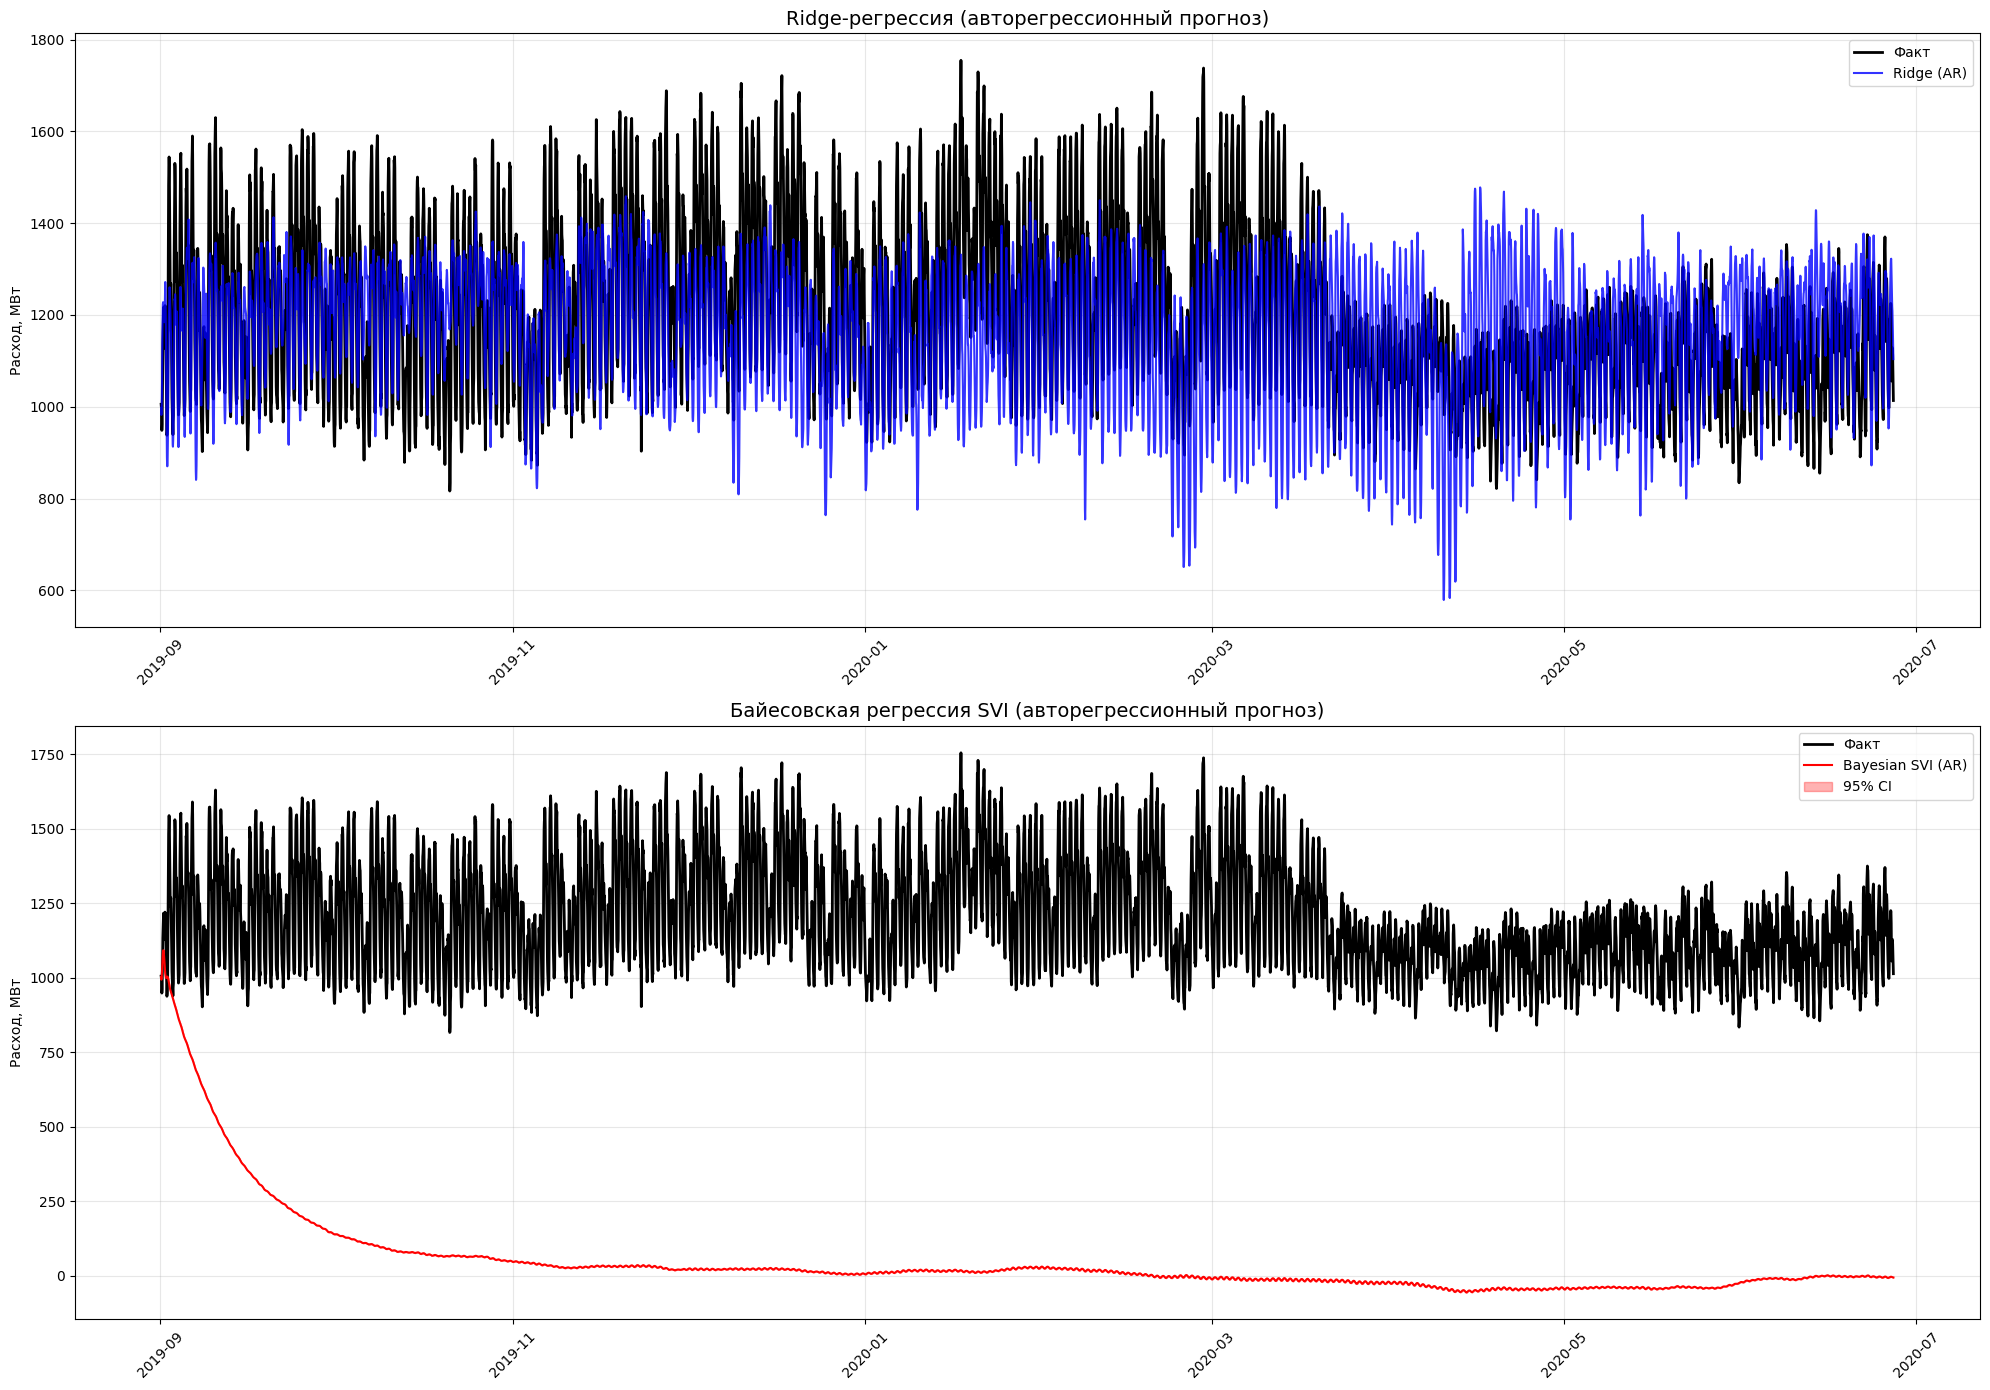

In [64]:
fig, axes = plt.subplots(2, 1, figsize=(20, 14))

# Ridge AR
axes[0].plot(
    dates_test[N_LAGS:], lag_label(y_test).to_numpy(),
    'k-', linewidth=2, label='Факт'
)
axes[0].plot(
    dates_test[N_LAGS:], pred_ridge_ar,
    'b-', linewidth=1.5, alpha=0.8, label='Ridge (AR)'
)
axes[0].set_ylabel('Расход, МВт')
axes[0].set_title(
    'Ridge-регрессия (авторегрессионный прогноз)', fontsize=14
)
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Bayesian SVI AR с доверительным интервалом
axes[1].plot(
    dates_test[N_LAGS:], lag_label(y_test).to_numpy(),
    'k-', linewidth=2, label='Факт'
)
axes[1].plot(
    dates_test[N_LAGS:], pred_bayes_ar,
    'r-', linewidth=1.5, label='Bayesian SVI (AR)'
)
axes[1].fill_between(
    dates_test[N_LAGS:],
    pred_bayes_ar - 1.96 * std_bayes_ar,
    pred_bayes_ar + 1.96 * std_bayes_ar,
    alpha=0.3, color='red', label='95% CI'
)
axes[1].set_ylabel('Расход, МВт')
axes[1].set_title(
    'Байесовская регрессия SVI (авторегрессионный прогноз)', fontsize=14
)
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

# Форматирование дат
for ax in axes:
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()

## Scatter plots: сравнение фактических и прогнозных значений ряда

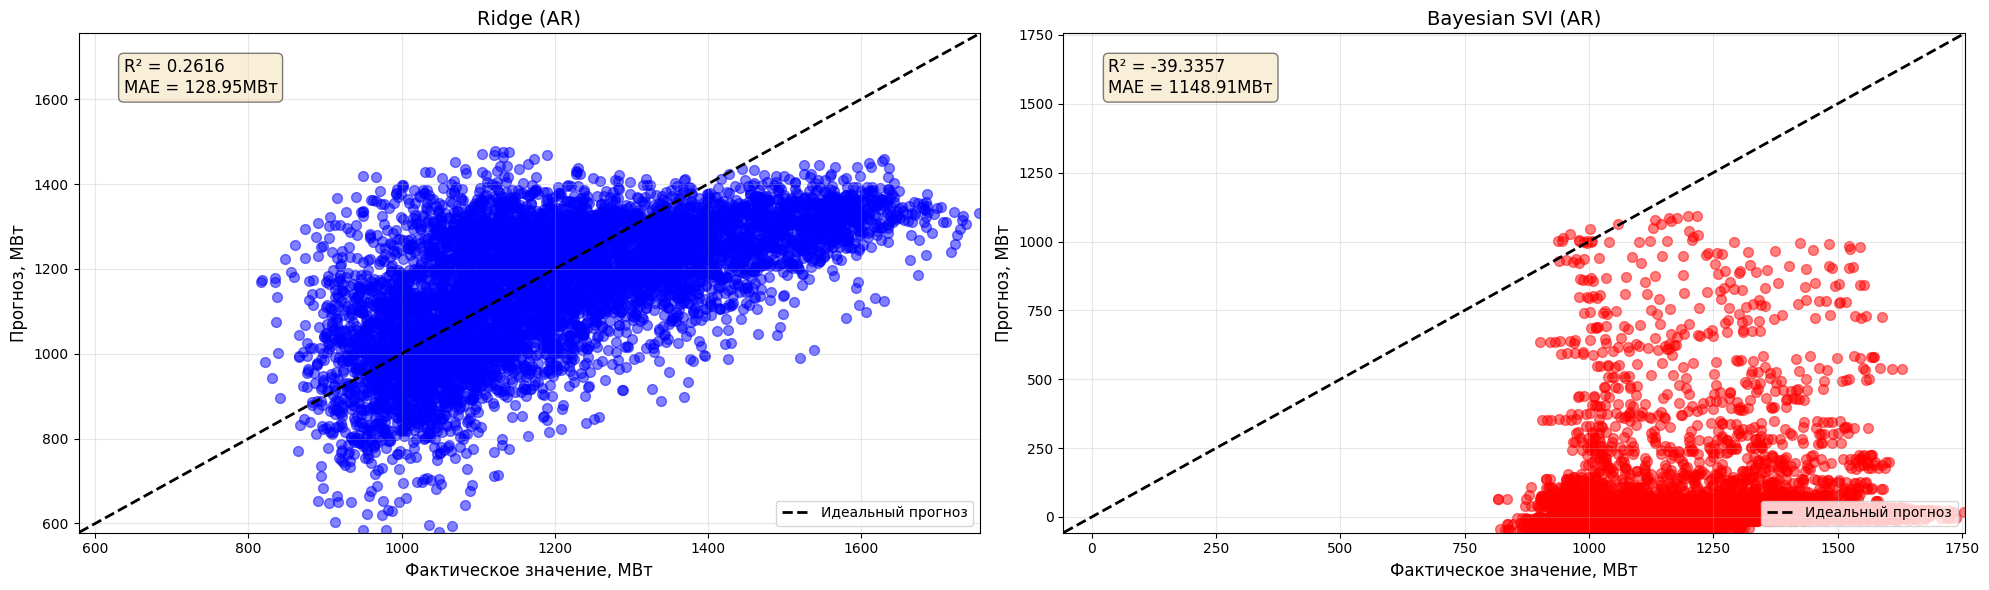

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

models_data = [
    ('Ridge (AR)', pred_ridge_ar, 'blue'),
    ('Bayesian SVI (AR)', pred_bayes_ar, 'red')
]

y_true = lag_label(y_test).to_numpy()

for ax, (name, pred, color) in zip(axes, models_data):
    ax.scatter(y_true, pred, alpha=0.5, c=color, s=50)

    min_val = min(y_true.min(), pred.min())
    max_val = max(y_true.max(), pred.max())
    ax.plot(
        [min_val, max_val], [min_val, max_val],
        'k--', linewidth=2, label='Идеальный прогноз'
    )

    ax.set_xlim(min_val - 1, max_val + 1)
    ax.set_ylim(min_val - 1, max_val + 1)

    r2 = r2_score(y_true, pred)
    mae = mean_absolute_error(y_true, pred)
    ax.text(
        0.05, 0.95, f'R² = {r2:.4f}\nMAE = {mae:.2f}МВт',
        transform=ax.transAxes, fontsize=12, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    )

    ax.set_xlabel('Фактическое значение, МВт', fontsize=12)
    ax.set_ylabel('Прогноз, МВт', fontsize=12)
    ax.set_title(f'{name}', fontsize=14)
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Распределение ошибок моделей

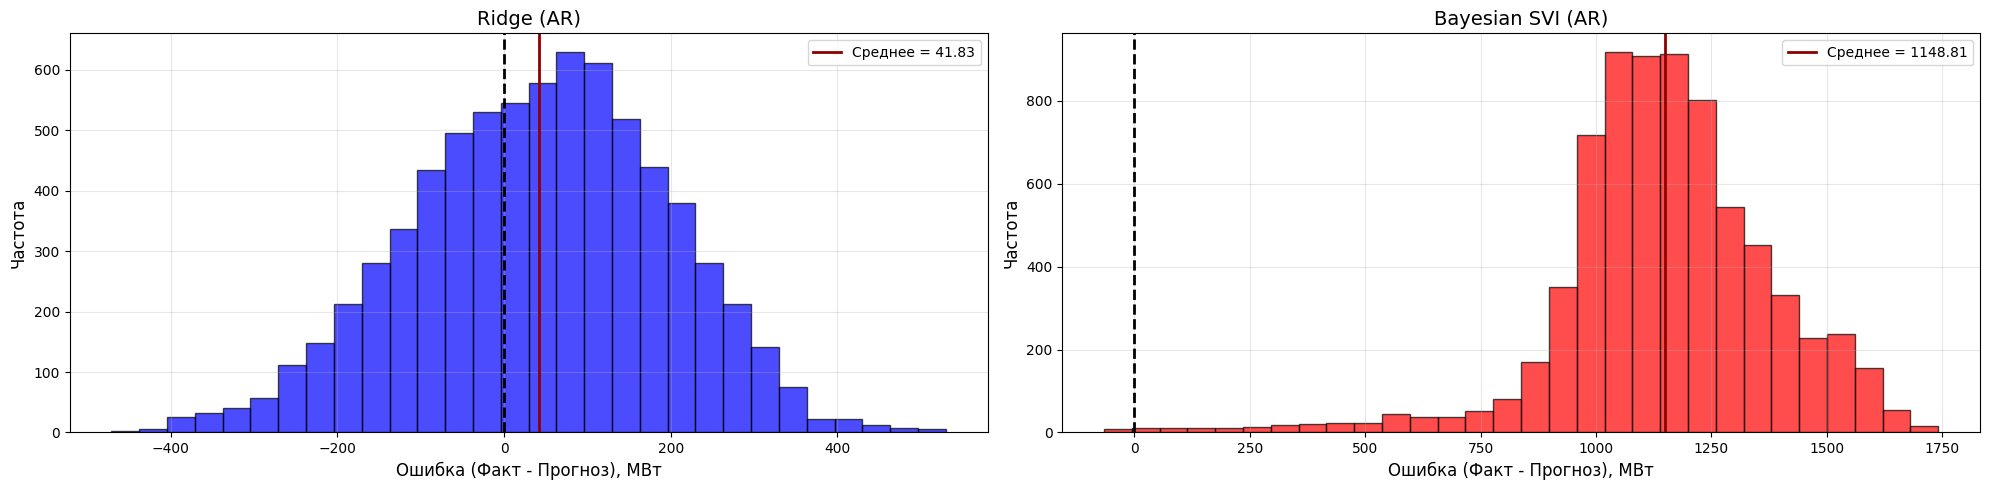

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

y_true = lag_label(y_test).to_numpy()

errors_data = [
    ('Ridge (AR)', y_true - pred_ridge_ar, 'blue'),
    ('Bayesian SVI (AR)', y_true - pred_bayes_ar, 'red')
]

for ax, (name, errors, color) in zip(axes, errors_data):
    ax.hist(errors, bins=30, color=color, alpha=0.7, edgecolor='black')
    ax.axvline(x=0, color='black', linestyle='--', linewidth=2)
    ax.axvline(
        x=errors.mean(), color='darkred', linestyle='-', linewidth=2,
        label=f'Среднее = {errors.mean():.2f}'
    )

    ax.set_xlabel('Ошибка (Факт - Прогноз), МВт', fontsize=12)
    ax.set_ylabel('Частота', fontsize=12)
    ax.set_title(f'{name}', fontsize=14)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Сравнение метрик на тестовых данных

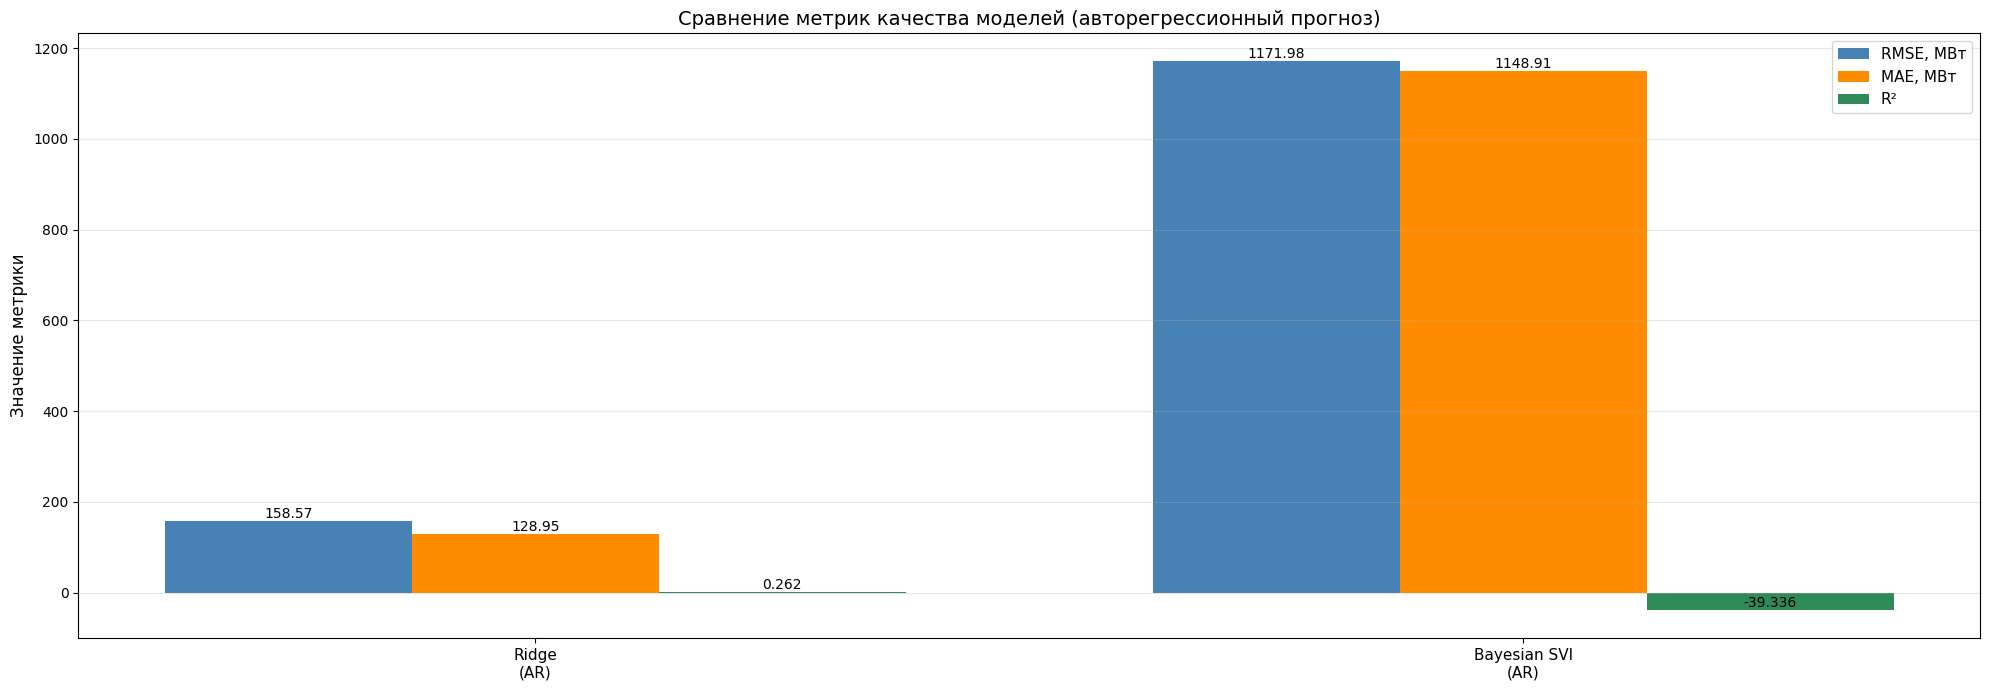

In [67]:
fig, ax = plt.subplots(figsize=(20, 7))

models = ['Ridge\n(AR)', 'Bayesian SVI\n(AR)']
predictions = [pred_ridge_ar, pred_bayes_ar]
y_true = lag_label(y_test).to_numpy()

# Расчёт метрик
rmse_vals = [
    np.sqrt(mean_squared_error(y_true, p)) for p in predictions
]
mae_vals = [mean_absolute_error(y_true, p) for p in predictions]
r2_vals = [r2_score(y_true, p) for p in predictions]

x = np.arange(len(models))
width = 0.25

bars1 = ax.bar(x - width, rmse_vals, width, label='RMSE, МВт', color='steelblue')
bars2 = ax.bar(x, mae_vals, width, label='MAE, МВт', color='darkorange')
bars3 = ax.bar(x + width, r2_vals, width, label='R²', color='seagreen')

ax.set_ylabel('Значение метрики', fontsize=12)
ax.set_title(
    'Сравнение метрик качества моделей (авторегрессионный прогноз)',
    fontsize=14
)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=11)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

# Подписи значений над столбцами
for bar, val in zip(bars1, rmse_vals):
    ax.text(
        bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02,
        f'{val:.2f}', ha='center', va='bottom', fontsize=10
    )
for bar, val in zip(bars2, mae_vals):
    ax.text(
        bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02,
        f'{val:.2f}', ha='center', va='bottom', fontsize=10
    )
for bar, val in zip(bars3, r2_vals):
    ax.text(
        bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02,
        f'{val:.3f}', ha='center', va='bottom', fontsize=10
    )

plt.tight_layout()
plt.show()

## Индивидуальное задание

Опираясь на представленное исследование и используя его в качестве образца, **выполните аналогичные действия с выбранным Вами датасетом**.

В процессе работы:

1. Выберите датасет, содержащий **временной ряд**. Датасеты можно найти, например, на [Kaggle](https://www.kaggle.com/datasets) и [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php). Датасет должен содержать целевую переменную и **хотя бы один** дополнительный признак.

2. Выполните **разведочный анализ** датасета: исследуйте временную структуру, сезонность, тренды. Выполните требуемые **преобразования признаков** (масштабирование, бинаризация и др.).

3. Разделите датасет на **обучающую**, **валидационную** и **тестовую** части с сохранением временного порядка.

4. Реализуйте **трансформер лаговых признаков** для построения авторегрессионной модели заданного порядка $p$.

5. Реализуйте **Ridge-регрессию** с автоматическим подбором коэффициента регуляризации через кросс-валидацию по временным рядам (TimeSeriesSplit).

6. Составьте **байесовскую линейную модель** для решения задачи регрессии. Запишите априорные распределения весов, правдоподобие и вид апостериорного распределения.

7. Реализуйте байесовскую модель на **PyTorch** с использованием **стохастического вариационного вывода (SVI)**. Используйте Mean-Field приближение и трюк репараметризации.

8. **Обучите** обе модели. Для байесовской модели визуализируйте значения ELBO в процессе обучения.

9. Разработайте процедуру **авторегрессионного прогнозирования** для обеих моделей: предсказания предыдущих шагов должны использоваться как входные признаки для следующих.

10. **Визуализируйте** прогнозы обеих моделей на тестовой выборке. Для байесовской модели отобразите **доверительные интервалы** (95% CI).

11. **Вычислите метрики качества** (RMSE, MAE, R²) для обеих моделей в авторегрессионном режиме. Критически оцените полученные результаты.

12. Постройте **scatter-диаграммы** «факт и прогноз» и **гистограммы ошибок** для обеих моделей.

13. Проведите **сравнительный анализ** частотного и байесовского подходов: точность, качество оценки неопределённости, вычислительная сложность.

14. Сделайте **выводы** по работе.



## Вопросы для подготовки к отчёту

1. Основные понятия теории вероятностей: плотность распределения, правило нормировки, совместная плотность вероятности, математическое ожидание, дисперсия, условная плотность вероятности. Условная независимость.

2. Обращение условного распределения. Теорема Байеса и роль каждого из её компонентов в байесовском моделировании.

3. Понятие графических вероятностных моделей. Представление вероятностных отношений в виде графа. Байесовская сеть. Наблюдаемые и латентные величины, их обозначения в графических моделях. Нотация «планок» в графических моделях. Глобальные и локальные латентные переменные. Примеры.

4. Классический и байесовский подходы к машинному обучению, их сравнительный анализ. Пример линейной регрессии с точки зрения обоих подходов. Постановка задачи и основная проблема байесовского вывода, способы её решения.

5. Понятие сэмплирования случайной величины. Способы сэмплирования. Теорема об обратной функции распределения и её применение для сэмплирования. Сэмплирование с отклонением (Rejection sampling). Сэмплирование по важности (Importance sampling). Forward sampling.

6. Вариационный инференс как метод решения задачи байесовского вывода. Идея вариационного инференса. Дивергенция Кульбака-Лейблера в задаче вариационного инференса. Вариационная нижняя оценка правдоподобия данных.

7. Вариационный инференс как оптимизационная задача. Стохастический вариационный инференс. Проблема расчёта градиента от оценки математического ожидания. Трюк репараметризации. Пример для нормального распределения.

8. Амортизированный вариационный инференс: назначение, сущность и особенности.  Отличие амортизированного инференса от классического вариационного вывода. Понятие Inference Network, примеры архитектур.

9. Понятие байесовских нейронных сетей. Отличие от классических нейронных сетей. Построение байесовской нейронной сети. Виды неопределённости: эпистемическая и алеаторическая.

10. Авторегрессионные модели: определение, структура, область применения. Авторегрессионная модель порядка $p$. Выражение для факторизации совместного распределения переменных временного ряда, порождаемого AR-моделью.  Авторегрессионное прогнозирование, накопление ошибки и неопределённости при многошаговом прогнозе.


## Список рекомендуемой литературы

1. Дауни, А. Б. Байесовские модели / А. Б. Дауни ; перевод с английского В. А. Яроцкого. — Москва : ДМК Пресс, 2018. — 182 с. URL: https://e.lanbook.com/book/131695 (дата обращения: 13.02.2024). — Режим доступа: для авториз. пользователей.

2. Barber, D. Bayesian Reasoning and Machine Learning / D. Barber // Cambridge University Press, 2012. URL: [http://www0.cs.ucl.ac.uk/staff/d.barber/brml/](http://www0.cs.ucl.ac.uk/staff/d.barber/brml/) (дата обращения: 13.02.2024).

3. Bishop, M.C. Pattern Recognition and Machine Learning / M.C. Bishop // Springer, 2006. — 738 с. URL: [https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf) (дата обращения: 13.02.2024).

4. Hoffman M., Blei D. M, Wang C., Paisley J. Stochastic Variational Inference [Электронный ресурс] // arXiv.org. 2013. Дата обновления: 22.04.2013. URL: https://arxiv.org/abs/1206.7051 (дата обращения: 22.05.2024).

5. Ranganath R., Gerrish S., Blei D.M. Black Box Variational Inference [Электронный ресурс] // arXiv.org. 2013. Дата обновления: 31.12.2013. URL: https://arxiv.org/pdf/1401.0118 (дата обращения: 22.05.2024).

6. Ganguly A., Jain S., Watchareeruetai U. Amortized Variational Inference: A Systematic Review [Электронный ресурс] // arXiv.org. 2023. Дата обновления: 24.10.2013. URL: https://arxiv.org/pdf/2209.10888

7. Box G. E. P., Jenkins G. M., Reinsel G. C. Time Series Analysis: Forecasting and Control. — 4th ed. — Wiley, 2015. — 720 с.